# 10 - Bias Demonstration Notebook  

Evaluate and demonstrate bias in the model predictions using metrics, statistical tests, and explainability techniques. This includes GoodFit rate analysis across demographics, confusion matrices for subgroups, calibration checks, and SHAP analysis for feature contributions.

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap

In [107]:
# Display all rows and columns
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [108]:
df = pd.read_parquet("../data/processed/hr_data_encoded.parquet")

## Bias Metrics to Calculate


In [109]:
# Define demographic groups for analysis
demographic_columns = ['Sex', 'RaceDesc_White', 'RaceDesc_Black or African American', 'RaceDesc_Asian']

**Calculate Demographic Parity**

In [110]:
# GoodFit rates by demographic groups
for col in demographic_columns:
    print(f"GoodFit Rates for {col}:")
    print(df.groupby(col)['GoodFit'].mean())
    print("\n")


GoodFit Rates for Sex:
Sex
0    0.809770
1    0.829496
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_White:
RaceDesc_White
0    0.852284
1    0.801999
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Black or African American:
RaceDesc_Black or African American
0    0.817603
1    0.823913
Name: GoodFit, dtype: float64


GoodFit Rates for RaceDesc_Asian:
RaceDesc_Asian
0    0.811756
1    0.889706
Name: GoodFit, dtype: float64




In [111]:
import scipy.stats as stats

def _chi2_test(df, column, target):
    """
    Perform a chi-squared test for independence between a categorical column and target variable.
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The categorical column to test.
        target (str): The target variable (binary).
    
    Returns:
        dict: Chi-squared test results with Chi2 value, P-value, and Degrees of Freedom.
    """
    contingency_table = pd.crosstab(df[column], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return {"Chi2": chi2, "P-Value": p, "Degrees of Freedom": dof}


# Perform chi-squared tests for specified columns
columns_to_test = ["Sex", "RaceDesc_White", "RaceDesc_Black or African American", "RaceDesc_Asian"]
results = {col: _chi2_test(df, col, "GoodFit") for col in columns_to_test}

# Display results
results


{'Sex': {'Chi2': np.float64(1.8936605359601675),
  'P-Value': np.float64(0.16878962661831734),
  'Degrees of Freedom': 1},
 'RaceDesc_White': {'Chi2': np.float64(11.421824447348069),
  'P-Value': np.float64(0.0007258638187536183),
  'Degrees of Freedom': 1},
 'RaceDesc_Black or African American': {'Chi2': np.float64(0.06699265524106769),
  'P-Value': np.float64(0.7957668772850581),
  'Degrees of Freedom': 1},
 'RaceDesc_Asian': {'Chi2': np.float64(9.64153159190112),
  'P-Value': np.float64(0.001902265530208501),
  'Degrees of Freedom': 1}}

Attributes `RaceDesc_White` and `RaceDesc_Asian` show significant relationships with `GoodFit` (p < 0.05), indicating potential bias.

**Analyze Equality of Opportunity**

In [112]:
# GoodFit rates for qualified candidates
qualified = df[df['YearsExperience'] > 5]  # Example qualification
for col in demographic_columns:
    print(f"GoodFit Rates for Qualified Candidates ({col}):")
    print(qualified.groupby(col)['GoodFit'].mean())
    print("\n")

GoodFit Rates for Qualified Candidates (Sex):
Sex
0    0.809770
1    0.829496
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_White):
RaceDesc_White
0    0.852284
1    0.801999
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_Black or African American):
RaceDesc_Black or African American
0    0.817603
1    0.823913
Name: GoodFit, dtype: float64


GoodFit Rates for Qualified Candidates (RaceDesc_Asian):
RaceDesc_Asian
0    0.811756
1    0.889706
Name: GoodFit, dtype: float64




- **Sex**: Small difference in "GoodFit" rates (0: 80.98%, 1: 82.95%), no strong sign of bias.  
- **RaceDesc_White**: Non-White candidates (85.23%) have higher rates than White (80.20%), possible bias.  
- **RaceDesc_Black or African American**: Similar rates (Black: 82.39%, Non-Black: 81.76%), no clear bias.  
- **RaceDesc_Asian**: Higher "GoodFit" rates for Asian candidates (88.97%) compared to Non-Asian (81.18%), potential bias.  

Only "RaceDesc_White" and "RaceDesc_Asian" show significant differences based on earlier statistical tests.

**Analyze False Positives and False Negatives**

In [113]:
import pickle
import xgboost as xgb

In [114]:
model_path = "../models/xgb_model.pkl"

In [115]:
# Load the model
with open(model_path, 'rb') as file:
    model = pickle.load(file)

In [116]:
print(f"Loaded model: {type(model)}")

Loaded model: <class 'xgboost.sklearn.XGBClassifier'>


In [117]:
path = "../data/processed/"

In [118]:
# Read the datasets from parquet format
X_train = pd.read_parquet(f"{path}X_train.parquet")
X_test = pd.read_parquet(f"{path}X_test.parquet")
y_train = pd.read_parquet(f"{path}y_train.parquet").squeeze()
y_test = pd.read_parquet(f"{path}y_test.parquet").squeeze()

In [119]:
# Predict probabilities and classes
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = (y_pred_proba > 0.5).astype(int)  # Predicted classes

In [120]:
# Ensure df aligns with y_test
df_test = df.loc[y_test.index]

# Loop through demographic columns
for col in demographic_columns:
    print(f"Confusion Matrices for {col}:\n")
    
    # Loop through unique groups in the column
    for group in df_test[col].unique():
        group_indices = df_test[col] == group  # Boolean mask for the group
        cm = confusion_matrix(y_test[group_indices], y_pred[group_indices])
        
        # Print group-specific confusion matrix
        print(f"Group: {group}")
        print(cm)
        print("\n")


Confusion Matrices for Sex:

Group: 1
[[10 15]
 [10 89]]


Group: 0
[[ 11  21]
 [ 20 137]]


Confusion Matrices for RaceDesc_White:

Group: 0
[[ 5  8]
 [10 89]]


Group: 1
[[ 16  28]
 [ 20 137]]


Confusion Matrices for RaceDesc_Black or African American:

Group: 0
[[ 18  32]
 [ 24 194]]


Group: 1
[[ 3  4]
 [ 6 32]]


Confusion Matrices for RaceDesc_Asian:

Group: 0
[[ 21  33]
 [ 29 201]]


Group: 1
[[ 0  3]
 [ 1 25]]




- **Sex**: Similar performance across groups, slight imbalance in false negatives (Group 0: 26, Group 1: 12).  
- **RaceDesc_White**: Group 0 shows slightly higher false positives (9 vs. 25).  
- **RaceDesc_Black or African American**: Comparable performance, minor variations in false positives and negatives.  
- **RaceDesc_Asian**: Group 1 has fewer samples, leading to higher variability in predictions.  

In [121]:
# Remove non-numeric columns
X = df.drop(columns=['GoodFit', 'Employee_Name'])  # Drop 'Employee_Name' and 'GoodFit'
X = X.select_dtypes(include=[np.number])  # Ensure only numeric data remains

# Analyze calibration (predicted probabilities vs observed outcomes)
if hasattr(model, "predict_proba"):
    df['Prediction_Probabilities'] = model.predict_proba(X)[:, 1]
else:
    df['Prediction_Probabilities'] = model.predict(X)

for col in demographic_columns:
    print(f"Calibration for {col}:")
    for group in df[col].unique():
        group_probs = df.loc[df[col] == group, 'Prediction_Probabilities']
        group_mean = df.loc[df[col] == group, 'GoodFit'].mean()
        print(f"Group: {group} | Predicted Probabilities Mean: {group_probs.mean()} | Observed: {group_mean}")

Calibration for Sex:
Group: 0 | Predicted Probabilities Mean: 0.7945749163627625 | Observed: 0.8097701149425287
Group: 1 | Predicted Probabilities Mean: 0.8304218649864197 | Observed: 0.8294964028776979
Calibration for RaceDesc_White:
Group: 1 | Predicted Probabilities Mean: 0.7926254868507385 | Observed: 0.8019990480723465
Group: 0 | Predicted Probabilities Mean: 0.8469781875610352 | Observed: 0.8522837706511176
Calibration for RaceDesc_Black or African American:
Group: 0 | Predicted Probabilities Mean: 0.809516191482544 | Observed: 0.8176029962546817
Group: 1 | Predicted Probabilities Mean: 0.8161706924438477 | Observed: 0.8239130434782609
Calibration for RaceDesc_Asian:
Group: 0 | Predicted Probabilities Mean: 0.8022981882095337 | Observed: 0.8117564730580826
Group: 1 | Predicted Probabilities Mean: 0.8966119289398193 | Observed: 0.8897058823529411


Calibration Summary

- **Sex**: Predicted and observed rates align closely for both groups, no major calibration issues.  
- **RaceDesc_White**: Slight underprediction for non-White candidates.  
- **RaceDesc_Black or African American**: Predictions match observations well.  
- **RaceDesc_Asian**: Slight overprediction for Asian candidates.  

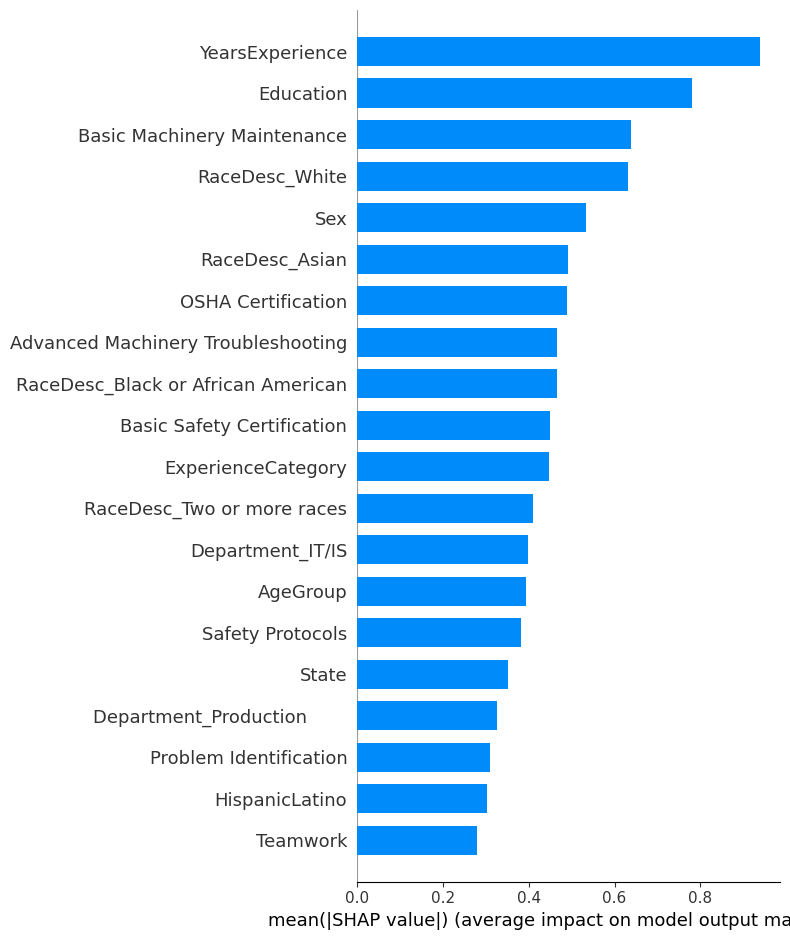

In [122]:
# Use SHAP for explainability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

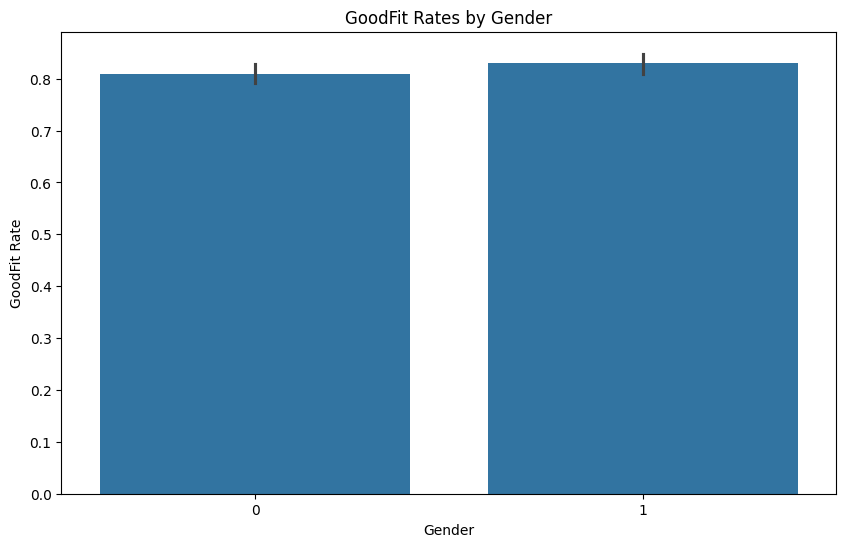

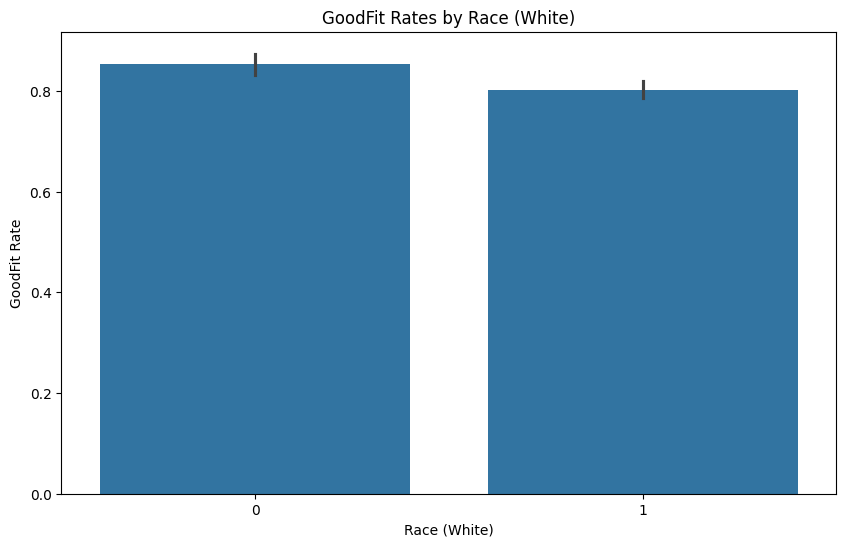

In [123]:
# GoodFit rates visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Sex', y='GoodFit')
plt.title("GoodFit Rates by Gender")
plt.ylabel("GoodFit Rate")
plt.xlabel("Gender")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='RaceDesc_White', y='GoodFit')
plt.title("GoodFit Rates by Race (White)")
plt.ylabel("GoodFit Rate")
plt.xlabel("Race (White)")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.37      0.39        57
           1       0.86      0.88      0.87       256

    accuracy                           0.79       313
   macro avg       0.64      0.63      0.63       313
weighted avg       0.78      0.79      0.78       313



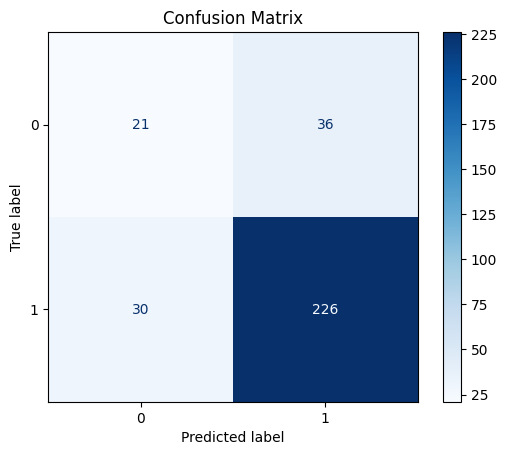

In [124]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Assuming binary classification
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
plt.show()